# Интеллектуальный анализ работы хранилища данных на основании обработки логов
## Задача 
- Найти высоконагруженные “горячие” объекты хранилища данных и спрогнозировать потенциальный рост нагрузки.
## Описание задачи:
На основе предоставленных логов хранилища необходимо разработать алгоритм обработки данных и прогнозирования будущей нагрузки. Важно частью задачи является выявление и распределение объектов хранилища по различным критериям.

 В качестве исходных данных предоставлен набор логов, которые содержат запросы к базе данных GreenPlum. Нужно предложить метод быстрой обработки этих данных. Выделению отдельных объектов, к которым чаще всего обращаются пользователи. Выявления самых “тяжелыx” и самых “горячих” объектов. Прогнозирование нагрузки на систему в разные временные отрезки.

In [1]:
#!pip install catboost

In [2]:
import os
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict

from catboost import CatBoostRegressor, cv, Pool
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None

In [3]:
# Откроем файлы по неделям
def path_open(name, pth1, pth2):
    if os.path.exists(pth1):
        name = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        name = pd.read_csv(pth2)
    else:
        print('Something is wrong')
        
path_open('wk1', 'log_week_end.csv', 
          'D:\IT\Hackatones\Skolkovo\data\log_week_end.csv'
         )
path_open('wk2', 'log_week_2_end.csv', 
          'D:\IT\Hackatones\Skolkovo\data\log_week_2_end.csv'
         )

wk1, wk2 = (
    pd.read_csv('D:\IT\Hackatones\Skolkovo\data\log_week_end.csv'),
    pd.read_csv('D:\IT\Hackatones\Skolkovo\data\log_week_2_end.csv')
)

wk1.info()
display(wk1.head(2))
print('---------------------------------')
wk2.info()
wk2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641138 entries, 0 to 641137
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   rn       641138 non-null  int64 
 1   loguser  641138 non-null  object
 2   query    641138 non-null  object
dtypes: int64(1), object(2)
memory usage: 14.7+ MB


,rn,loguser,query
0,2530,etl_2048,"from tbl_157224,join tbl_157223"
1,5658,etl_2048,"from tbl_195789,join tbl_195791"


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630078 entries, 0 to 630077
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   rn        630078 non-null  int64 
 1   loguser   630078 non-null  object
 2   query     630078 non-null  object
 3   duration  557929 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.2+ MB


,rn,loguser,query,duration
0,16493642,etl_528,from tbl_111329,duration: 240.851 ms
1,12761109,etl_528,from tbl_127353,duration: 2165.935 ms


In [4]:
wk1.shape, wk2.shape

((641138, 3), (630078, 4))

<AxesSubplot:title={'center':'Данные за вторую неделю'}, ylabel='Frequency'>

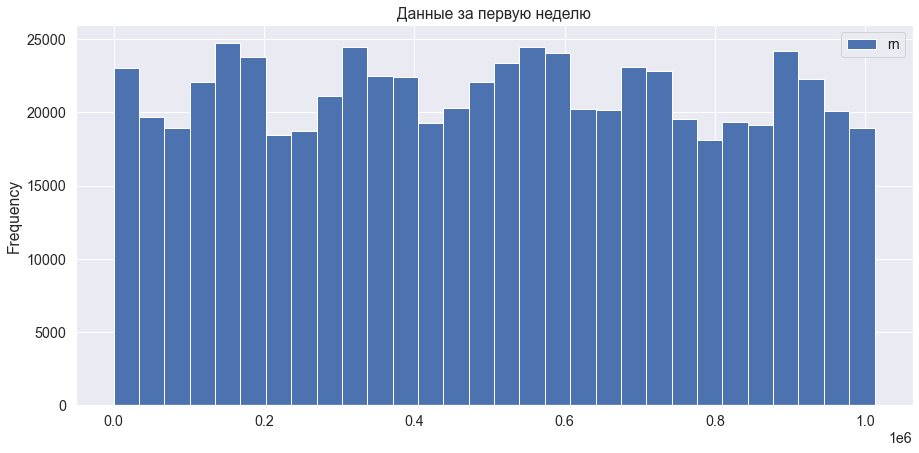

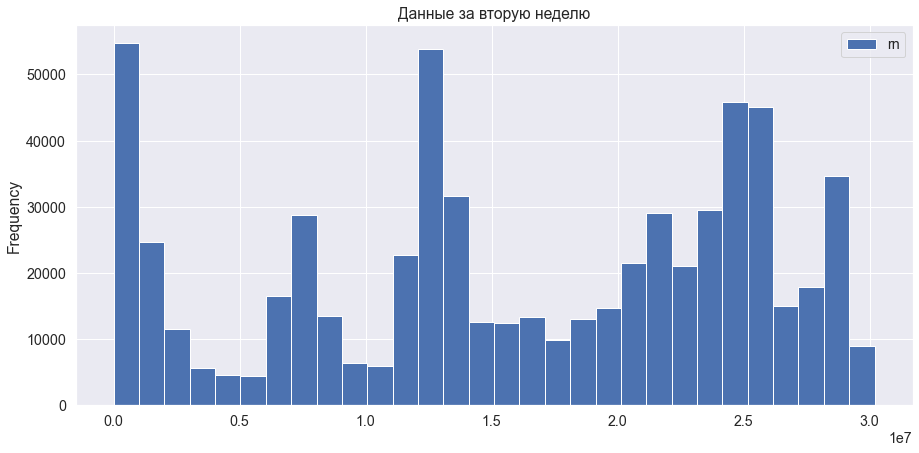

In [5]:
# Посмотрим данные за первую неделю
wk1.plot(title='Данные за первую неделю', kind='hist', grid=True, bins=30, figsize=(15, 7))

# Посмотрим данные за вторую неделю
wk2.plot(title='Данные за вторую неделю', kind='hist', grid=True, bins=30, figsize=(15, 7))

## Высоконагруженные объекты
- большие по количеству

In [6]:
# Создадим функцию, которая выделит номера таблиц и посчитает количество запросов из столбца query
def table_counter(data:pd.Series):
  mylist = []
  data = data['query'].str.replace('[^0-9,]', '', regex=True).str.lower()
  data = data.str.split(',').to_list()

  for a in range(len(data)):
      for b in range (len(data[a])):
          mylist.append(data[a][b])
  return mylist

In [7]:
# Получим список
tables_list = table_counter(wk1) + table_counter(wk2)

In [8]:
# Подсчет количества повторений элементов в последовательности.
tables_cnt_dict = Counter(tables_list)

# Отсортируем по убыванию
tables_cnt_dict = sorted(tables_cnt_dict.items(), key=lambda x: x[1], reverse=True)
tables_cnt_dict

[('7207', 55626),
 ('11022', 55606),
 ('33595', 38653),
 ('33623', 33795),
 ('33570', 17160),
 ('27182', 14341),
 ('14714', 11623),
 ('20007', 11498),
 ('211513', 9602),
 ('33583', 7432),
 ('225891', 7347),
 ('20055', 6961),
 ('33569', 6866),
 ('12737', 6790),
 ('24696', 6719),
 ('27178', 6519),
 ('26976', 6424),
 ('9859', 6220),
 ('19156', 5124),
 ('26776', 4994),
 ('10108', 4969),
 ('10099', 4943),
 ('12551', 4820),
 ('8053', 4768),
 ('22189', 4365),
 ('258439', 4354),
 ('10303', 4247),
 ('19794', 4133),
 ('33185', 3990),
 ('20560', 3779),
 ('387011', 3670),
 ('15844', 3668),
 ('18550', 3618),
 ('19181', 3471),
 ('42632', 3463),
 ('29040', 3417),
 ('27350', 3328),
 ('19103', 3223),
 ('8577', 3218),
 ('29455', 3190),
 ('211512', 3159),
 ('178332', 3140),
 ('9012', 2987),
 ('26789', 2971),
 ('29188', 2903),
 ('260713', 2852),
 ('20381', 2850),
 ('26975', 2835),
 ('191495', 2824),
 ('26974', 2795),
 ('32599', 2794),
 ('33577', 2714),
 ('14638', 2659),
 ('19170', 2658),
 ('60734', 2656),

## Топ 10 "горячих таблиц"

In [9]:
# Топ 10 горячих- высоконагруженных обеъктов
hot = pd.DataFrame(tables_cnt_dict, columns=['tables', 'frequency_of_use'])[:10]
hot

,tables,frequency_of_use
0,7207,55626
1,11022,55606
2,33595,38653
3,33623,33795
4,33570,17160
5,27182,14341
6,14714,11623
7,20007,11498
8,211513,9602
9,33583,7432


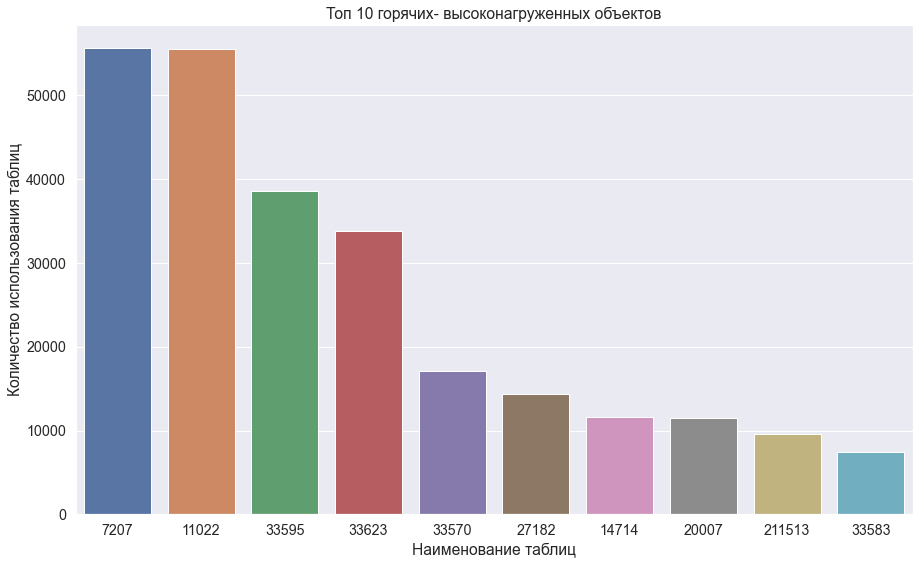

За две недели максимальное количество использования таблиц у тройки:
 таблица "7207"- 55626 раз,
 таблица "11022"- 55606 раз,
 таблица "33595"- 38653 раз.


In [10]:
# Построим график
plt.figure(figsize=(15, 9))
sns.barplot(data=hot, x="tables", y="frequency_of_use")
plt.title("Топ 10 горячих- высоконагруженных объектов")
plt.ylabel('Количество использования таблиц')
plt.xlabel('Наименование таблиц')
plt.show()
print('За две недели максимальное количество использования таблиц у тройки:\n таблица "{}"- {} раз,\n таблица "{}"- {} раз,\n таблица "{}"- {} раз.'
.format(
    hot.iloc[hot['frequency_of_use'].idxmax()]['tables'], hot['frequency_of_use'].max(), 
    hot.iloc[1]['tables'], hot.iloc[1]['frequency_of_use'], 
    hot.iloc[2]['tables'], hot.iloc[2]['frequency_of_use'])
    )

## Тяжелые объекты
- большие по длительности

In [11]:
# Вытащили цифры длительности
wk2['time_target'] = wk2['duration'].str.replace('[^0-9.]', '', regex=True).astype('float')

# Вытащили номера таблиц
wk2['tables'] = wk2['query'].str.replace('[^0-9,]', '', regex=True).str.lower()

# Разделили списки таблиц по запятой, посчитали
wk2['tables_count'] = wk2['tables'].str.split(',').apply(len)

# выдает False когда есть пропуск
tables_time = wk2[wk2['time_target'].notna()]
tables_time.info()
tables_time.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557929 entries, 0 to 630077
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   rn            557929 non-null  int64  
 1   loguser       557929 non-null  object 
 2   query         557929 non-null  object 
 3   duration      557929 non-null  object 
 4   time_target   557929 non-null  float64
 5   tables        557929 non-null  object 
 6   tables_count  557929 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 34.1+ MB


,rn,loguser,query,duration,time_target,tables,tables_count
0,16493642,etl_528,from tbl_111329,duration: 240.851 ms,240.85,111329,1
1,12761109,etl_528,from tbl_127353,duration: 2165.935 ms,"2,165.93",127353,1


In [12]:
tables_time = (
    tables_time
    .groupby('tables')['time_target']
    .median()
    .reset_index()
)
tables_time.sample(3)

,tables,time_target
1121,"10419,10419",103.04
12318,166511,68.14
36322,"8526,8526","2,942.32"


In [13]:
# Возьмем таблицы с большой длительностью
tables_time = tables_time.loc[tables_time['tables'].str.split(',').apply(len) == 1]
tables_time['time_target'] = tables_time['time_target'].astype('int')
tables_time = tables_time.sort_values('time_target', ascending=False)
tables_time.head(3)

,tables,time_target
9142,14996,11219406
28929,308121,4690881
26610,281142,2473347


In [14]:
# Создадим словарь: номер таблицы и время в мс
tables_time_dict = tables_time.set_index('tables')['time_target'].to_dict()
tables_time_dict

{'14996': 11219406,
 '308121': 4690881,
 '281142': 2473347,
 '309364': 2159433,
 '305654': 1718636,
 '230191': 874169,
 '188049': 738126,
 '173857': 718979,
 '308374': 622265,
 '92506': 584563,
 '235832': 552227,
 '22880': 459657,
 '8912': 443438,
 '77369': 434026,
 '235012': 400647,
 '184521': 312010,
 '193385': 300450,
 '294878': 289875,
 '92705': 272516,
 '229684': 269403,
 '345672': 240644,
 '203622': 206772,
 '203615': 206496,
 '203628': 205968,
 '203634': 205916,
 '203608': 205808,
 '203612': 205537,
 '203631': 205418,
 '195070': 201968,
 '240262': 193120,
 '34932': 179901,
 '259460': 177328,
 '184921': 172139,
 '157330': 165376,
 '234343': 163653,
 '93862': 152121,
 '158031': 148601,
 '229683': 145985,
 '381023': 144431,
 '239484': 143762,
 '193436': 132216,
 '92674': 130918,
 '20065': 126932,
 '268635': 123500,
 '185104': 119347,
 '183714': 116693,
 '268987': 112561,
 '199870': 107486,
 '20396': 106794,
 '157844': 106297,
 '229937': 104353,
 '71000': 102973,
 '157616': 98010,
 

## Топ 10 "тяжелых таблиц"

In [15]:
hard = pd.DataFrame.from_dict(tables_time_dict.items()).rename(columns={0:'tables', 1:'median_time_ms'})[:10]
hard

,tables,median_time_ms
0,14996,11219406
1,308121,4690881
2,281142,2473347
3,309364,2159433
4,305654,1718636
5,230191,874169
6,188049,738126
7,173857,718979
8,308374,622265
9,92506,584563


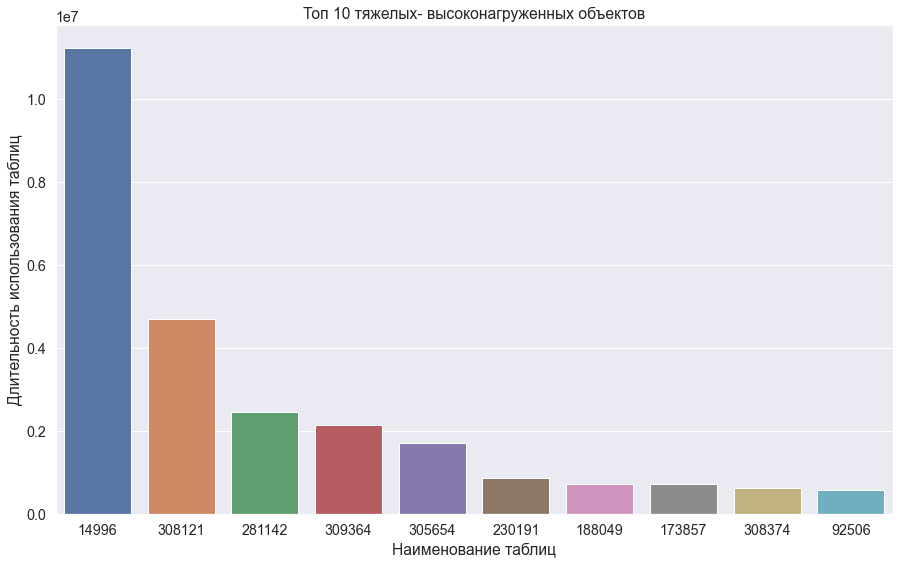

За две недели максимальная длительность использования таблиц у тройки:
 таблица "14996"- 11219406 ms,
 таблица "308121"- 4690881 ms,
 таблица "281142"- 2473347 ms.


In [16]:
# Построим график
plt.figure(figsize=(15, 9))
sns.barplot(data=hard, x="tables", y="median_time_ms")
plt.title("Топ 10 тяжелых- высоконагруженных объектов")
plt.ylabel('Длительность использования таблиц')
plt.xlabel('Наименование таблиц')
plt.show()
print('За две недели максимальная длительность использования таблиц у тройки:\n таблица "{}"- {} ms,\n таблица "{}"- {} ms,\n таблица "{}"- {} ms.'
.format(
    hard.iloc[hard['median_time_ms'].idxmax()]['tables'], hard['median_time_ms'].max(), 
    hard.iloc[1]['tables'], hard.iloc[1]['median_time_ms'], 
    hard.iloc[2]['tables'], hard.iloc[2]['median_time_ms'])
    )

## Прогнозирования времени исполнения запроса по предоставленным данным
- Модель машинного обучения

## Препроцессинг

In [17]:
# удаление пропусков
wk2 = wk2.loc[wk2['time_target'].notna()]

wk2['query'] = wk2['query'].str.replace(',', ' ', regex=True)
wk2.head(2)

,rn,loguser,query,duration,time_target,tables,tables_count
0,16493642,etl_528,from tbl_111329,duration: 240.851 ms,240.85,111329,1
1,12761109,etl_528,from tbl_127353,duration: 2165.935 ms,"2,165.93",127353,1


### Feature engineering

- id юзера
- тип юзера

In [18]:
# Выделили номер юзера
wk2['user_id'] = wk2['loguser'].str.replace('[^0-9]', '', regex=True).astype(int)

# Привели к типу категориальный и номерацию 1-0 в зависимости от типа пользователя
wk2['user_kind'] = wk2['loguser'].str.replace('[_0-9]', '', regex=True).astype('category').cat.codes

In [19]:
wk2 = wk2.drop('loguser', axis=1)
wk2.sample(3)

,rn,query,duration,time_target,tables,tables_count,user_id,user_kind
370971,22983534,into tbl_21340 join tbl_21340,duration: 344.866 ms,344.87,"21340,21340",2,1151,1
65968,11856850,from tbl_7207 from tbl_11022,duration: 678.285 ms,678.28,"7207,11022",2,332,0
320103,13328033,from tbl_195563,duration: 14977.061 ms,"14,977.06",195563,1,2048,1


- общее время пользователя на все запросы
- кол-во запросов пользоватея за неделю
- медианное время пользователя по 1 запрос
- среднее кол-во таблиц в запросах пользователя

In [20]:
#общее время пользователя на все запросы
x = (
    wk2
    .groupby('user_id', as_index=False)['time_target']
    .sum()
    .rename(columns={'time_target':'sum_ms_time'})
)
display(x.sample(3))

wk2 = wk2.merge(x, on = 'user_id', how='left')
wk2['sum_ms_time'].fillna(0, inplace=True)
wk2.head(3)

,user_id,sum_ms_time
43,1189,"49,568.82"
39,1161,"9,368,125.74"
60,1625,"51,107.57"


,rn,query,duration,time_target,tables,tables_count,user_id,user_kind,sum_ms_time
0,16493642,from tbl_111329,duration: 240.851 ms,240.85,111329,1,528,1,"369,114,653.08"
1,12761109,from tbl_127353,duration: 2165.935 ms,"2,165.93",127353,1,528,1,"369,114,653.08"
2,28294808,from tbl_128986,duration: 17661.026 ms,"17,661.03",128986,1,528,1,"369,114,653.08"


In [21]:
#кол-во запросов пользоватея за неделю
x = (
    wk2.groupby('user_id', as_index=False)['query']
    .count()
    .rename(columns={'query':'cnt_queries'})
)
display(x.sample(3))
wk2 = wk2.merge(x, on = 'user_id', how='left')
wk2['cnt_queries'].fillna(0, inplace=True)
wk2.tail(3)

,user_id,cnt_queries
81,1956,5451
45,1226,85
82,1970,158


,rn,query,duration,time_target,tables,tables_count,user_id,user_kind,sum_ms_time,cnt_queries
557926,12924693,into tbl_83793 join tbl_83793 from tbl_83792,duration: 1190.617 ms,"1,190.62","83793,83793,83792",3,2048,1,"2,081,839,583.71",320398
557927,16756505,from tbl_15915,duration: 417.199 ms,417.20,15915,1,1151,1,"1,094,132,858.19",101918
557928,21023432,from tbl_83212,duration: 692.306 ms,692.31,83212,1,2048,1,"2,081,839,583.71",320398


In [22]:
#медианное время пользователя на 1 запрос
x = (
    wk2.groupby('user_id', as_index=False)['time_target']
    .median()
    .rename(columns={'time_target':'median_ms_time'})
)
display(x.sample(3))
wk2 = wk2.merge(x, on = 'user_id', how='left')
wk2['median_ms_time'].fillna(0, inplace=True)
wk2.sample(3)

,user_id,median_ms_time
87,2037,"9,384.08"
30,501,"1,887.30"
15,319,"1,351.06"


,rn,query,duration,time_target,tables,tables_count,user_id,user_kind,sum_ms_time,cnt_queries,median_ms_time
314673,16480336,from tbl_20764,duration: 1206.881 ms,"1,206.88",20764,1,1151,1,"1,094,132,858.19",101918,770.15
326575,24181976,from tbl_62025,duration: 424.744 ms,424.74,62025,1,2048,1,"2,081,839,583.71",320398,471.19
352115,20905416,from tbl_79971,duration: 24.441 ms,24.44,79971,1,2048,1,"2,081,839,583.71",320398,471.19


In [23]:
#среднее кол-во таблиц в запросах пользователя
x = (
    wk2.groupby('user_id', as_index=False)['tables_count']
    .mean()
    .rename(columns={'tables_count':'mean_table_count'})
)
display(x.sample(3))
wk2 = wk2.merge(x, on = 'user_id', how='left')
wk2['mean_table_count'].fillna(0, inplace=True)
wk2.sample(3)

,user_id,mean_table_count
35,1136,1.62
25,390,2.32
8,274,2.00


,rn,query,duration,time_target,tables,tables_count,user_id,user_kind,sum_ms_time,cnt_queries,median_ms_time,mean_table_count
239223,13211550,from tbl_166132,duration: 2920.948 ms,"2,920.95",166132,1,2048,1,"2,081,839,583.71",320398,471.19,1.49
373895,13435677,from tbl_202659,duration: 66637.999 ms,"66,638.00",202659,1,2048,1,"2,081,839,583.71",320398,471.19,1.49
480883,25789816,from tbl_9995,duration: 206.720 ms,206.72,9995,1,1151,1,"1,094,132,858.19",101918,770.15,1.66


### Удаляем выбросы в таргете(уменьшаем датасет для обучения)

In [24]:
Q1 = wk2[['time_target']].quantile(0.25)
Q3 = wk2[['time_target']].quantile(0.75)
IQR = Q3 - Q1

wk2 = wk2[~((wk2[['time_target']] < (Q1 - 1.5 * IQR)) |(wk2[['time_target']] > (Q3 + 1.5 * IQR))).any(axis=1)]
display(wk2.shape)
wk2.head(3)

(474978, 12)

,rn,query,duration,time_target,tables,tables_count,user_id,user_kind,sum_ms_time,cnt_queries,median_ms_time,mean_table_count
0,16493642,from tbl_111329,duration: 240.851 ms,240.85,111329,1,528,1,"369,114,653.08",47464,"1,130.01",1.16
1,12761109,from tbl_127353,duration: 2165.935 ms,"2,165.93",127353,1,528,1,"369,114,653.08",47464,"1,130.01",1.16
3,12703938,from tbl_155188,duration: 1047.568 ms,"1,047.57",155188,1,528,1,"369,114,653.08",47464,"1,130.01",1.16


### Подготовка данных для обучения

In [25]:
# Выберем столбцы 
feature_col = ['query', 'tables_count',
       'user_id', 'user_kind', 'sum_ms_time', 
       'cnt_queries', 'median_ms_time',
       'mean_table_count']

X = wk2[feature_col]
y = wk2['time_target'].values

# без перемешивания данных
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13, shuffle=False)


### Векторизация запросов

In [26]:
word_vectorizer = CountVectorizer(ngram_range=(1, 2))
wk2['query'] = wk2['query'].str.replace(',', ' ')
wk2['query'] = wk2['query'].str.replace('tbl_', ' ')
word_vectorizer.fit(X_train['query'])
train_word_features = word_vectorizer.transform(X_train['query'])
test_word_features = word_vectorizer.transform(X_val['query'])

X_train = hstack([X_train[feature_col[1:]].values, train_word_features])
X_val = hstack([X_val[feature_col[1:]].values, test_word_features])

### Модель машинного обучения

In [27]:
train_pool = Pool(
    X_train,
    y_train,
)
valid_pool = Pool(
    X_val,
    y_val,
)

In [28]:
# Обучим модель на 500 итерациях
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.03,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'verbose': 5
}

In [29]:
model = CatBoostRegressor(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 1235.9531306	test: 1239.5694579	best: 1239.5694579 (0)	total: 916ms	remaining: 7m 37s
5:	learn: 1221.1065539	test: 1224.8847829	best: 1224.8847829 (5)	total: 4.83s	remaining: 6m 37s
10:	learn: 1210.4301882	test: 1214.3921891	best: 1214.3921891 (10)	total: 8.43s	remaining: 6m 14s
15:	learn: 1202.6049898	test: 1206.6668470	best: 1206.6668470 (15)	total: 12.2s	remaining: 6m 7s
20:	learn: 1196.2038070	test: 1200.4543943	best: 1200.4543943 (20)	total: 15.9s	remaining: 6m 2s
25:	learn: 1191.6143646	test: 1196.0075834	best: 1196.0075834 (25)	total: 19.6s	remaining: 5m 57s
30:	learn: 1188.2650299	test: 1192.7690491	best: 1192.7690491 (30)	total: 23.3s	remaining: 5m 52s
35:	learn: 1185.9821214	test: 1190.5330248	best: 1190.5330248 (35)	total: 26.9s	remaining: 5m 46s
40:	learn: 1183.8286801	test: 1188.4284285	best: 1188.4284285 (40)	total: 30.4s	remaining: 5m 40s
45:	learn: 1182.1248000	test: 1186.7839239	best: 1186.7839239 (45)	total: 34s	remaining: 5m 35s
50:	learn: 1180.9379242	test

In [30]:
pred = model.predict(X_val)
print('Средняя абсолютная ошибка составляет -', round(mae(y_val, pred), 2), 'мс')

Средняя абсолютная ошибка составляет - 1165.18 мс


## Прогноз на основе данных запроса и юзера

In [31]:
def predict_query_time(loguser:str, query: str):
  d = {'loguser': loguser, 'query':query}
  data = pd.DataFrame([d], columns=d.keys())
  data['query'] = data['query'].str.replace(',', ' ', regex=True)
  data['tables'] = data['query'].str.replace('[^0-9,]', '', regex=True).str.lower()
  data['tables_count'] = data['tables'].str.split(',').apply(len)

  data['user_id'] = data['loguser'].str.replace('[^0-9]', '', regex=True).astype(int)
  data['user_kind'] = data['loguser'].str.replace('[_0-9]', '', regex=True).astype('category').cat.codes
  data = data.drop('loguser', axis=1)

  x = data.groupby('user_id', as_index=False)['query'].count().rename(columns={'query':'cnt_queries'})
  data = data.merge(x, on = 'user_id', how='left')
  data['cnt_queries'].fillna(0, inplace=True)

  x = data.groupby('user_id', as_index=False)['tables_count'].mean().rename(columns={'tables_count':'mean_table_count'})
  data = data.merge(x, on = 'user_id', how='left')
  data['mean_table_count'].fillna(0, inplace=True)

  data = data.merge(wk2[['user_id', 'sum_ms_time', 'median_ms_time']].drop_duplicates(), on='user_id', how='left')

  pred_word_features = word_vectorizer.transform(data['query'])

  test = hstack([data[feature_col[1:]].values, pred_word_features])

  pred = model.predict(test)

  txt = f'среднее время выполнения запроса - {round(pred[0] / 1000, 1)} +-1 сек'
  return txt

In [32]:
#введите юзера и его запрос в формате str
predict_query_time('dev_528', 'into 83793 join 83793 from 83792')

'среднее время выполнения запроса - 1.6 +-1 сек'

## Очень крутой результат! Обработка меньше одной секунды.